In [124]:
import copy
import random
import cv2
import functools
import torch
import torchmetrics
import pandas as pd
import seaborn as sns
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange
from torch.optim import Adam
from glob import glob
from torch import nn
from torchvision.transforms import functional
from torch.utils.data import Dataset, ConcatDataset, DataLoader, Subset
from torchvision import io


In [125]:
def reset_random_seeds():
    torch.manual_seed(54)
    random.seed(54)

### Подготовка датасета

In [126]:
class SelfieDataset(Dataset):
    def __init__(self, images, masks, transform=lambda x: x):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def _crop_image(self, img):
        return transforms.functional.crop(img, 0, 0, 768, 512)

    def __getitem__(self, idx):
        img = self.transform(self._crop_image(io.read_image(str(self.images[idx]))) / 255)
        mask = self.transform(self._crop_image(io.read_image(str(self.masks[idx]))) / 255)
        return img, mask

In [159]:
def show_images(image, mask):
    fig, axs = plt.subplots(ncols=2)
    axs[0].imshow(functional.to_pil_image(image))
    axs[1].imshow(functional.to_pil_image(mask))

In [129]:
images = sorted(glob("/kaggle/input/dataset/dataset/images/*"))
masks = sorted(glob("/kaggle/input/dataset/dataset/masks/*")

### Разделение датасета

In [130]:
test_portion = 0.1
train_dataset = SelfieDataset(
    images[int(len(images) * test_portion):],
    masks[int(len(masks) * test_portion):]
)
test_dataset = SelfieDataset(
    images=images[:int(len(images) * test_portion)],
    masks=masks[:int(len(masks) * test_portion)]
)

Train size: 1800
Test size: 200


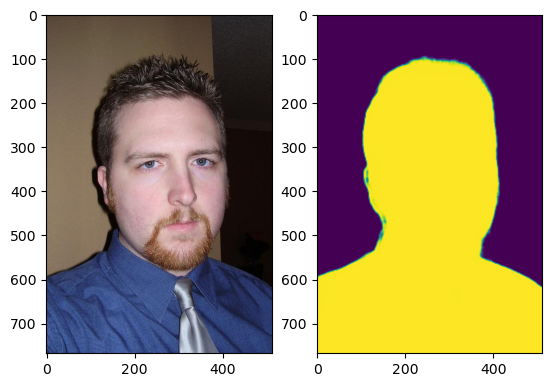

In [160]:
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

image, mask = train_dataset[0]

show_images(image, mask)

### Обучение

#### Реализация U-Net
Была взята с пары

In [132]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x
    
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

#### Переобучение на 4 картинках

Для переобучения на одном батче возьмем 80 эпох. В теории модель должна близко к идеальному научиться на train, но выдавать плохие результаты для данных test.

In [133]:
reset_random_seeds()

In [134]:
batch_size = 4

train_loader = DataLoader(
    Subset(train_dataset, range(batch_size)),
    batch_size=batch_size,
)
test_loader = DataLoader(
    Subset(test_dataset, range(batch_size)),
    batch_size=batch_size,
)

In [136]:
criterion = nn.BCEWithLogitsLoss()
jaccard = torchmetrics.JaccardIndex(task="binary")

In [137]:
def test(model, loader):
  model.eval()

  running_loss = 0.0
  jaccard_metr = 0.0
  with torch.no_grad():
      for x, y in tqdm(loader):
          outputs = model(x.cuda())
          loss = criterion(outputs, y.cuda())
          running_loss += loss.item()
          jaccard_metr += (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()

  return running_loss / len(loader), jaccard_metr / len(loader)

def train(epochs, model, train_loader, test_loader, optimizer):
  train_stats = []
  test_stats = []
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    jaccard_metr = 0.0
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(x.cuda())

        loss = criterion(outputs, y.cuda())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        jaccard_metr += (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()

    train_loss = running_loss / len(train_loader)
    train_jaccard = jaccard_metr / len(train_loader) 
    train_stat = (train_loss, train_jaccard)
     
    test_loss, test_jaccard = test(model, test_loader)
    test_stat = (test_loss, test_jaccard)
     
    train_stats.append(train_stat)
    test_stats.append(test_stat)
    print(epoch + 1, " Train loss: ", train_loss, ", train jaccard: ", train_jaccard, ", test loss: ", test_loss, ", test jaccard: ", test_jaccard)
    
  return train_stats, test_stats

In [138]:
model = UNET(3, 16, 1).cuda()
optimizer = Adam(model.parameters())

train_stats, test_stats = train(
    80, model, train_loader, test_loader, optimizer
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

1  Train loss:  0.6836809515953064 , train jaccard:  0.45739316940307617 , test loss:  0.6731691360473633 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2  Train loss:  0.600634753704071 , train jaccard:  0.5993145108222961 , test loss:  0.673021674156189 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

3  Train loss:  0.551396906375885 , train jaccard:  0.6727311015129089 , test loss:  0.6725882291793823 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

4  Train loss:  0.5181899070739746 , train jaccard:  0.7174844741821289 , test loss:  0.6721739768981934 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5  Train loss:  0.4955630302429199 , train jaccard:  0.7459287047386169 , test loss:  0.6717674136161804 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

6  Train loss:  0.4758080840110779 , train jaccard:  0.7696531414985657 , test loss:  0.671006441116333 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

7  Train loss:  0.4577119052410126 , train jaccard:  0.7895455956459045 , test loss:  0.6697249412536621 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

8  Train loss:  0.4490145146846771 , train jaccard:  0.7821103930473328 , test loss:  0.6680752038955688 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

9  Train loss:  0.4298180043697357 , train jaccard:  0.8088894486427307 , test loss:  0.6664009690284729 , test jaccard:  0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

10  Train loss:  0.42181310057640076 , train jaccard:  0.8050921559333801 , test loss:  0.6655175685882568 , test jaccard:  0.6974641680717468


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

11  Train loss:  0.40227359533309937 , train jaccard:  0.8633962869644165 , test loss:  0.6699596643447876 , test jaccard:  0.7055533528327942


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

12  Train loss:  0.3959362208843231 , train jaccard:  0.8679481744766235 , test loss:  0.6751043796539307 , test jaccard:  0.7179792523384094


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

13  Train loss:  0.37862443923950195 , train jaccard:  0.9150931239128113 , test loss:  0.748054027557373 , test jaccard:  0.05431615188717842


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

14  Train loss:  0.3944571018218994 , train jaccard:  0.8493694067001343 , test loss:  0.8774463534355164 , test jaccard:  0.011438477784395218


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

15  Train loss:  0.36777305603027344 , train jaccard:  0.907677948474884 , test loss:  0.9484298229217529 , test jaccard:  0.009235766716301441


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

16  Train loss:  0.3673635423183441 , train jaccard:  0.898439347743988 , test loss:  1.108757495880127 , test jaccard:  0.006843497045338154


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

17  Train loss:  0.359607070684433 , train jaccard:  0.9035686254501343 , test loss:  1.5028531551361084 , test jaccard:  0.0038377621676772833


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

18  Train loss:  0.3496454656124115 , train jaccard:  0.9143366813659668 , test loss:  1.8084344863891602 , test jaccard:  0.0029766580555588007


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

19  Train loss:  0.3430473208427429 , train jaccard:  0.9282435178756714 , test loss:  1.7859258651733398 , test jaccard:  0.003946051467210054


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

20  Train loss:  0.3363385796546936 , train jaccard:  0.9457953572273254 , test loss:  1.8272947072982788 , test jaccard:  0.003584411693736911


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

21  Train loss:  0.33244335651397705 , train jaccard:  0.9398959875106812 , test loss:  1.6970895528793335 , test jaccard:  0.004463451448827982


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

22  Train loss:  0.3216307461261749 , train jaccard:  0.9518182873725891 , test loss:  1.4822723865509033 , test jaccard:  0.007187954615801573


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

23  Train loss:  0.31733086705207825 , train jaccard:  0.9567965269088745 , test loss:  1.2744566202163696 , test jaccard:  0.0121209267526865


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

24  Train loss:  0.3102917969226837 , train jaccard:  0.9612588286399841 , test loss:  1.1736564636230469 , test jaccard:  0.04338213801383972


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

25  Train loss:  0.30646806955337524 , train jaccard:  0.96442049741745 , test loss:  1.0504201650619507 , test jaccard:  0.10679349303245544


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

26  Train loss:  0.3001098334789276 , train jaccard:  0.9676064252853394 , test loss:  0.8743261694908142 , test jaccard:  0.32774361968040466


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

27  Train loss:  0.2968565821647644 , train jaccard:  0.9655250310897827 , test loss:  0.9981002807617188 , test jaccard:  0.2639245092868805


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

28  Train loss:  0.30808669328689575 , train jaccard:  0.9465745687484741 , test loss:  0.9922000765800476 , test jaccard:  0.3288736343383789


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

29  Train loss:  0.3002304136753082 , train jaccard:  0.954039454460144 , test loss:  0.8863195180892944 , test jaccard:  0.4234192371368408


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

30  Train loss:  0.2921338975429535 , train jaccard:  0.9643056988716125 , test loss:  0.7550119161605835 , test jaccard:  0.531359076499939


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

31  Train loss:  0.29361435770988464 , train jaccard:  0.9470464587211609 , test loss:  0.6821195483207703 , test jaccard:  0.5937793850898743


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

32  Train loss:  0.2852838933467865 , train jaccard:  0.9626591801643372 , test loss:  0.5590006709098816 , test jaccard:  0.6897168755531311


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

33  Train loss:  0.28173792362213135 , train jaccard:  0.9640383720397949 , test loss:  0.5468621253967285 , test jaccard:  0.697797417640686


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

34  Train loss:  0.28078097105026245 , train jaccard:  0.9598075747489929 , test loss:  0.5537100434303284 , test jaccard:  0.697731077671051


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

35  Train loss:  0.2764507830142975 , train jaccard:  0.963049590587616 , test loss:  0.5843170881271362 , test jaccard:  0.6775720119476318


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

36  Train loss:  0.2693231999874115 , train jaccard:  0.969841718673706 , test loss:  0.6117478609085083 , test jaccard:  0.6610782742500305


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

37  Train loss:  0.26494500041007996 , train jaccard:  0.9772970676422119 , test loss:  0.657986581325531 , test jaccard:  0.6267473697662354


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

38  Train loss:  0.26275599002838135 , train jaccard:  0.9741914868354797 , test loss:  0.6520336866378784 , test jaccard:  0.6324771642684937


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

39  Train loss:  0.25776562094688416 , train jaccard:  0.979928731918335 , test loss:  0.5865402221679688 , test jaccard:  0.687127411365509


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

40  Train loss:  0.2542222738265991 , train jaccard:  0.9850223064422607 , test loss:  0.6110990047454834 , test jaccard:  0.6671843528747559


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

41  Train loss:  0.2523730397224426 , train jaccard:  0.9811961650848389 , test loss:  0.5893523097038269 , test jaccard:  0.6813666820526123


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

42  Train loss:  0.24833893775939941 , train jaccard:  0.9849179983139038 , test loss:  0.5557753443717957 , test jaccard:  0.7018961906433105


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

43  Train loss:  0.2451249063014984 , train jaccard:  0.9853466153144836 , test loss:  0.5683104395866394 , test jaccard:  0.6931324601173401


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

44  Train loss:  0.2403561919927597 , train jaccard:  0.9896637797355652 , test loss:  0.5992418527603149 , test jaccard:  0.6737490296363831


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

45  Train loss:  0.237757608294487 , train jaccard:  0.9899386763572693 , test loss:  0.6112270355224609 , test jaccard:  0.6644018292427063


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

46  Train loss:  0.23582646250724792 , train jaccard:  0.9903892874717712 , test loss:  0.6107966303825378 , test jaccard:  0.6618330478668213


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

47  Train loss:  0.23252658545970917 , train jaccard:  0.9914918541908264 , test loss:  0.6062513589859009 , test jaccard:  0.6592444777488708


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

48  Train loss:  0.23019415140151978 , train jaccard:  0.990748941898346 , test loss:  0.6028475761413574 , test jaccard:  0.6595761775970459


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

49  Train loss:  0.227603480219841 , train jaccard:  0.991888701915741 , test loss:  0.601058840751648 , test jaccard:  0.6624569892883301


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

50  Train loss:  0.22532734274864197 , train jaccard:  0.9919090867042542 , test loss:  0.6058860421180725 , test jaccard:  0.6596710085868835


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

51  Train loss:  0.22263167798519135 , train jaccard:  0.992382287979126 , test loss:  0.619268536567688 , test jaccard:  0.6515915393829346


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

52  Train loss:  0.22008006274700165 , train jaccard:  0.9928750991821289 , test loss:  0.6374552249908447 , test jaccard:  0.6410255432128906


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

53  Train loss:  0.21802429854869843 , train jaccard:  0.9928150773048401 , test loss:  0.6546605229377747 , test jaccard:  0.6304749846458435


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

54  Train loss:  0.2158934324979782 , train jaccard:  0.9928235411643982 , test loss:  0.6698193550109863 , test jaccard:  0.6187148094177246


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

55  Train loss:  0.21343448758125305 , train jaccard:  0.9932329058647156 , test loss:  0.6877217292785645 , test jaccard:  0.6036648154258728


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

56  Train loss:  0.21103844046592712 , train jaccard:  0.9936259984970093 , test loss:  0.7091655135154724 , test jaccard:  0.5877037644386292


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

57  Train loss:  0.2089213728904724 , train jaccard:  0.9935839772224426 , test loss:  0.7362858653068542 , test jaccard:  0.5694414973258972


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

58  Train loss:  0.20684480667114258 , train jaccard:  0.9936895370483398 , test loss:  0.7653777599334717 , test jaccard:  0.549919843673706


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

59  Train loss:  0.20465931296348572 , train jaccard:  0.9940664172172546 , test loss:  0.7897145748138428 , test jaccard:  0.5331811904907227


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

60  Train loss:  0.20254385471343994 , train jaccard:  0.9941825866699219 , test loss:  0.8037320375442505 , test jaccard:  0.5237292647361755


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

61  Train loss:  0.2005406618118286 , train jaccard:  0.9941447973251343 , test loss:  0.8054510951042175 , test jaccard:  0.5234171748161316


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

62  Train loss:  0.19851438701152802 , train jaccard:  0.994231641292572 , test loss:  0.8005428314208984 , test jaccard:  0.5286597013473511


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

63  Train loss:  0.19648730754852295 , train jaccard:  0.9943937063217163 , test loss:  0.7959245443344116 , test jaccard:  0.5349950194358826


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

64  Train loss:  0.19453226029872894 , train jaccard:  0.9944474101066589 , test loss:  0.795226514339447 , test jaccard:  0.5396038889884949


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

65  Train loss:  0.19261127710342407 , train jaccard:  0.9944167137145996 , test loss:  0.7976197004318237 , test jaccard:  0.5423742532730103


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

66  Train loss:  0.19067160785198212 , train jaccard:  0.9945225715637207 , test loss:  0.8001881837844849 , test jaccard:  0.5449248552322388


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

67  Train loss:  0.1887504905462265 , train jaccard:  0.9947788119316101 , test loss:  0.8001269102096558 , test jaccard:  0.5484075546264648


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

68  Train loss:  0.186884343624115 , train jaccard:  0.9948774576187134 , test loss:  0.796578586101532 , test jaccard:  0.5536172389984131


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

69  Train loss:  0.18504264950752258 , train jaccard:  0.9948956966400146 , test loss:  0.7918946146965027 , test jaccard:  0.5592522621154785


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

70  Train loss:  0.18320469558238983 , train jaccard:  0.994911789894104 , test loss:  0.7901287078857422 , test jaccard:  0.5628437995910645


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

71  Train loss:  0.18138772249221802 , train jaccard:  0.9950125813484192 , test loss:  0.7933245897293091 , test jaccard:  0.5631181597709656


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

72  Train loss:  0.17960351705551147 , train jaccard:  0.9951292872428894 , test loss:  0.7996298670768738 , test jaccard:  0.5615003705024719


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

73  Train loss:  0.1778491586446762 , train jaccard:  0.9952507019042969 , test loss:  0.8063985705375671 , test jaccard:  0.5590143203735352


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

74  Train loss:  0.17610816657543182 , train jaccard:  0.9953499436378479 , test loss:  0.8118596076965332 , test jaccard:  0.5569700002670288


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

75  Train loss:  0.17437013983726501 , train jaccard:  0.9954540133476257 , test loss:  0.8155719041824341 , test jaccard:  0.5560084581375122


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

76  Train loss:  0.17265944182872772 , train jaccard:  0.9955079555511475 , test loss:  0.8179177045822144 , test jaccard:  0.5563473701477051


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

77  Train loss:  0.1709831804037094 , train jaccard:  0.9955483078956604 , test loss:  0.8193010091781616 , test jaccard:  0.5580978989601135


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

78  Train loss:  0.169314906001091 , train jaccard:  0.9956488609313965 , test loss:  0.8201836347579956 , test jaccard:  0.5604134202003479


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

79  Train loss:  0.16765964031219482 , train jaccard:  0.9958093166351318 , test loss:  0.8211345672607422 , test jaccard:  0.5619821548461914


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

80  Train loss:  0.16603884100914001 , train jaccard:  0.9958787560462952 , test loss:  0.822265625 , test jaccard:  0.562747597694397


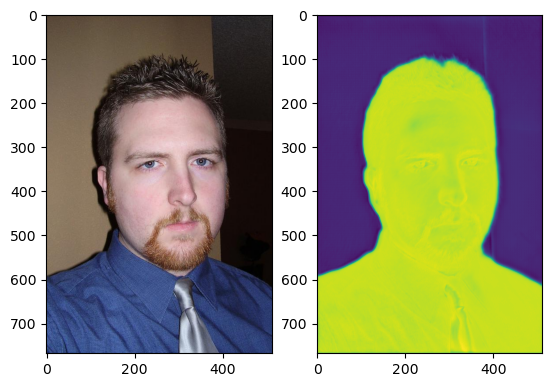

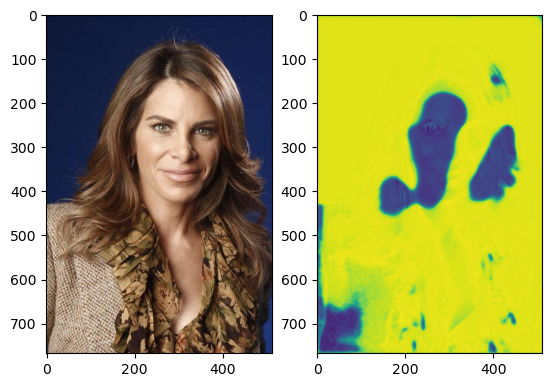

In [139]:
model.eval()

X, _ = train_dataset[0]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
show_images(X, pred)

X, _ = test_dataset[0]
with torch.no_grad():
    pred = model(X.cuda().unsqueeze(0))[0].cpu()
show_images(X, pred)

In [140]:
def show_stats(train_stats, test_stats, title):
    loss_results, jaccard_results = [], []
    i = 1
    for i, (loss, jaccard) in enumerate(train_stats):
        loss_results.append(
            {
                "Epoch": i,
                "Type": "Train",
                "Value": loss,
            }
        )
        jaccard_results.append(
            {
                "Epoch": i,
                "Type": "Train",
                "Value": jaccard,
            }
        )
    for i, (loss, jaccard) in enumerate(test_stats):
        loss_results.append(
            {
                "Epoch": i,
                "Type": "Test",
                "Value": loss,
            }
        )
        jaccard_results.append(
            {
                "Epoch": i,
                "Type": "Test",
                "Value": jaccard,
            }
        )
    
    lossDf = pd.DataFrame(loss_results)
    jaccardDf = pd.DataFrame(jaccard_results)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(15, 7))
    sns.lineplot(lossDf, x="Epoch", y="Value", hue="Type", style="Type", markers=True, dashes=False, ax=axs[0])
    axs[0].set_title("Loss")

    sns.lineplot(jaccardDf, x="Epoch", y="Value", hue="Type", style="Type", markers=True, dashes=False, ax=axs[1])
    axs[1].set_title("Jaccard index")

    fig.suptitle(title)
    fig.tight_layout()

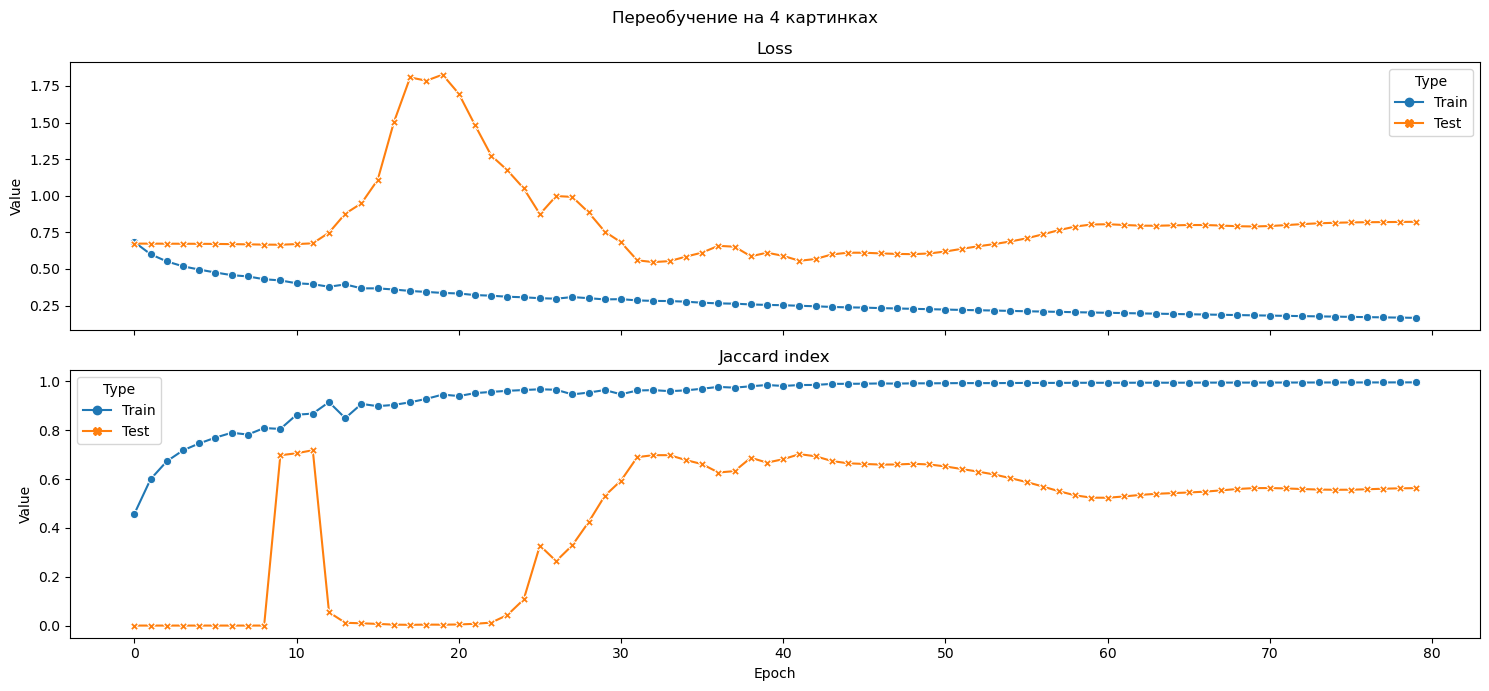

In [141]:
show_stats(train_stats, test_stats, "Переобучение на 4 картинках")

Как видно по приведенным выше картинкам и графикам, модель и правда выдает отличные результаты на тренировочных данных, но не умеет работать с тестовыми.

#### Обучение на всем датасете

In [142]:
batch_size = 20

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

model = UNET(3, 16, 1).cuda()
optimizer = Adam(model.parameters())

train_stats, test_stats = train(
    30, model, train_loader, test_loader, optimizer
)

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1  Train loss:  0.529575655526585 , train jaccard:  0.6145712077617645 , test loss:  0.4231454521417618 , test jaccard:  0.7397124111652374


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2  Train loss:  0.404237100481987 , train jaccard:  0.7184279766347673 , test loss:  0.3522879719734192 , test jaccard:  0.7953553915023803


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

3  Train loss:  0.3477316980560621 , train jaccard:  0.7553787191708883 , test loss:  0.4096545040607452 , test jaccard:  0.771663498878479


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

4  Train loss:  0.3119309994909498 , train jaccard:  0.7807112296422323 , test loss:  0.3179011091589928 , test jaccard:  0.8167771399021149


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

5  Train loss:  0.27398927956819535 , train jaccard:  0.8079782479339176 , test loss:  0.2604687437415123 , test jaccard:  0.8404408752918243


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

6  Train loss:  0.24340081330802704 , train jaccard:  0.829851418071323 , test loss:  0.2594479560852051 , test jaccard:  0.843109804391861


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

7  Train loss:  0.217809136543009 , train jaccard:  0.8482352077960968 , test loss:  0.22512078434228897 , test jaccard:  0.8655272543430328


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

8  Train loss:  0.20157557063632542 , train jaccard:  0.8593624042140113 , test loss:  0.21076165586709977 , test jaccard:  0.8763588309288025


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

9  Train loss:  0.18279496737652354 , train jaccard:  0.8729086246755388 , test loss:  0.202408105134964 , test jaccard:  0.8817441165447235


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

10  Train loss:  0.16951971492833562 , train jaccard:  0.8822247286637624 , test loss:  0.1993304207921028 , test jaccard:  0.880304217338562


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

11  Train loss:  0.1590186208486557 , train jaccard:  0.8895120998223622 , test loss:  0.2102970525622368 , test jaccard:  0.8722252666950225


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

12  Train loss:  0.1487802797721492 , train jaccard:  0.8969888375865088 , test loss:  0.2454102635383606 , test jaccard:  0.8460918068885803


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

13  Train loss:  0.14430584617786937 , train jaccard:  0.9001137521531847 , test loss:  0.2256052613258362 , test jaccard:  0.8620275795459748


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

14  Train loss:  0.13365056208438345 , train jaccard:  0.9078540775511 , test loss:  0.18403830230236054 , test jaccard:  0.8899761617183686


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

15  Train loss:  0.12632195477684338 , train jaccard:  0.9126772887176937 , test loss:  0.1788896180689335 , test jaccard:  0.8931348860263825


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

16  Train loss:  0.11951540700263447 , train jaccard:  0.9178749587800767 , test loss:  0.17155494615435601 , test jaccard:  0.8993468761444092


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

17  Train loss:  0.11320692093835936 , train jaccard:  0.9222997526327769 , test loss:  0.1675563298165798 , test jaccard:  0.9039197087287902


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

18  Train loss:  0.1076302041610082 , train jaccard:  0.9265178859233856 , test loss:  0.15891994908452034 , test jaccard:  0.9073694348335266


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

19  Train loss:  0.10266027798255285 , train jaccard:  0.9300721373822954 , test loss:  0.1997866153717041 , test jaccard:  0.8816781759262085


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

20  Train loss:  0.09918882379101382 , train jaccard:  0.9319645239247216 , test loss:  0.17356298640370368 , test jaccard:  0.8983090221881866


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

21  Train loss:  0.09386478335493141 , train jaccard:  0.9364954464965396 , test loss:  0.15820049867033958 , test jaccard:  0.9051243305206299


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

22  Train loss:  0.08772389168540637 , train jaccard:  0.941155034965939 , test loss:  0.17129600942134857 , test jaccard:  0.9002539634704589


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

23  Train loss:  0.08192893850306669 , train jaccard:  0.9454652448495229 , test loss:  0.18079226911067964 , test jaccard:  0.8988976657390595


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

24  Train loss:  0.08231237071255842 , train jaccard:  0.9448709852165647 , test loss:  0.1751651257276535 , test jaccard:  0.9022887349128723


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

25  Train loss:  0.08598244633111689 , train jaccard:  0.9417516675260332 , test loss:  0.18059590607881545 , test jaccard:  0.9010246396064758


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

26  Train loss:  0.07775788712832662 , train jaccard:  0.9477370891306135 , test loss:  0.1853504866361618 , test jaccard:  0.897720354795456


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

27  Train loss:  0.06757300674087471 , train jaccard:  0.9555306242571937 , test loss:  0.18412594720721245 , test jaccard:  0.9019611656665802


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

28  Train loss:  0.06638175828589334 , train jaccard:  0.956157523393631 , test loss:  0.18901558816432953 , test jaccard:  0.9022825300693512


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

29  Train loss:  0.06339735823373 , train jaccard:  0.9582031932142046 , test loss:  0.18166725262999533 , test jaccard:  0.9038358271121979


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

30  Train loss:  0.06376882816354433 , train jaccard:  0.9577561736106872 , test loss:  0.1984051764011383 , test jaccard:  0.8886760950088501


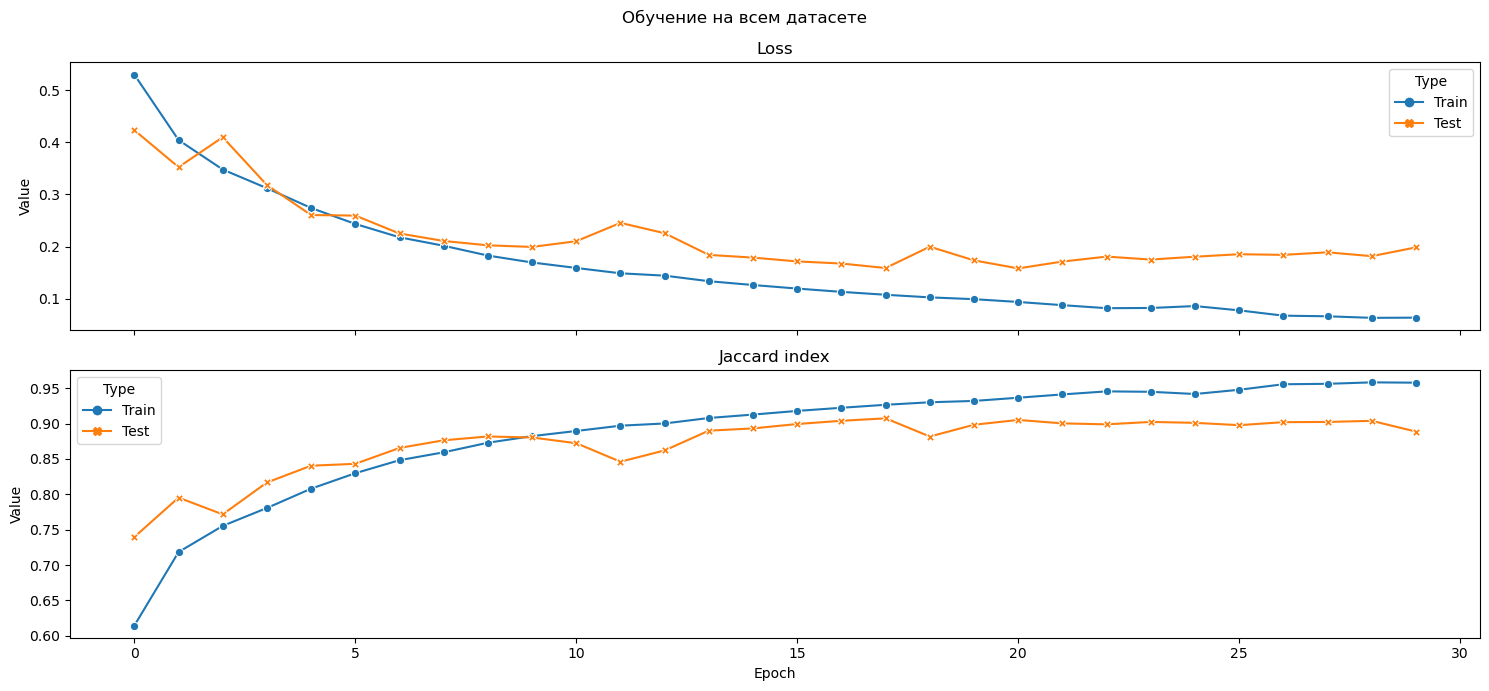

In [143]:
show_stats(train_stats, test_stats, "Обучение на всем датасете")

Согласно графикам, наилучшие результаты были на 17-ой эпохе, а с 20-ой и далее результаты для тестовых данных почти не менялись.

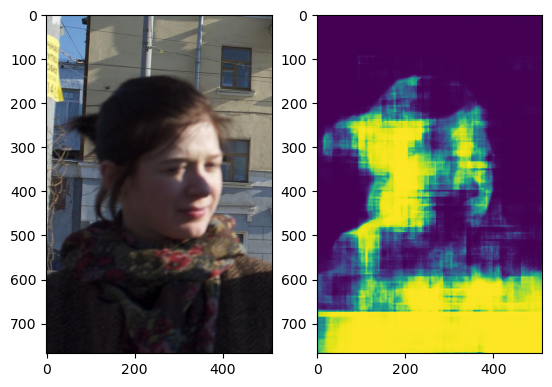

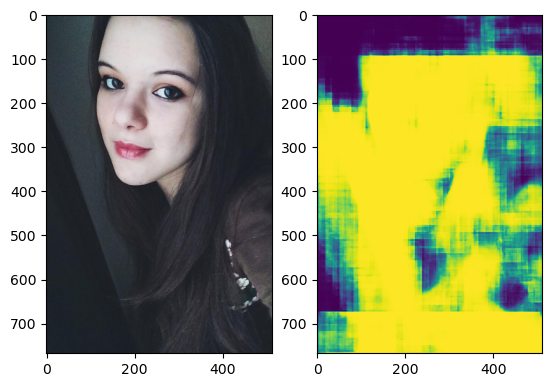

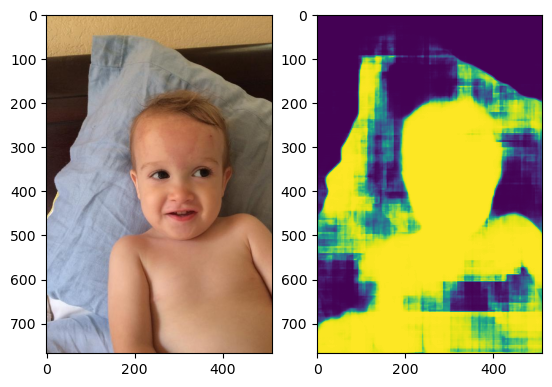

In [144]:
model.eval()

def show_worst_images(model, n, idx):
    if len(idx) == 0:
        results = []
        with torch.no_grad():
            for i, (x, y) in enumerate(test_dataset):
                outputs = model(x.cuda().unsqueeze(0))[0]
                jaccard_metr = (jaccard(outputs.cpu(), y.cpu() > jaccard.threshold)).item()
                results.append((jaccard_metr, i))
        idx = [i for _, i in sorted(results)[:n]]
    with torch.no_grad():
        for i in idx:
            x, y = test_dataset[i]
            outputs = model(x.cuda().unsqueeze(0))[0]
            show_images(x, nn.functional.sigmoid(outputs.cpu()))

    return idx

worst_idx = show_worst_images(model, 3, [])

Топ-3 самых плохих предсказаний лучше, чем при переобучении, но все еще силуэт выделяет достаточно плохо.

### Улучшение без изменения архитектуры

In [146]:
reset_random_seeds()

Увеличим количество тренировочных данных, используя аугментации, а именно отразим изображения и изменим яркость, контрастность, насыщенность и оттенок изображения.

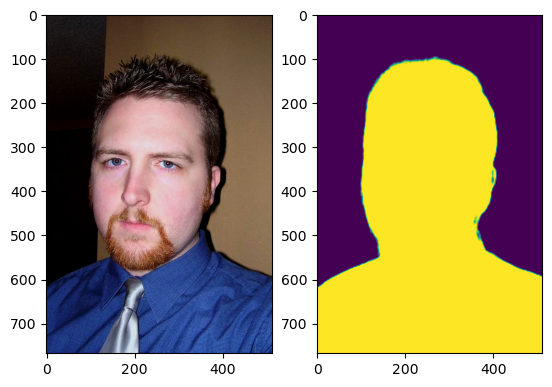

In [147]:
batch_size = 20

augmentations = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=1),
        transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.5, hue=0.1)
    ]
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = augmentations

augmented_image, augmented_mask = train_dataset_augmented[0]
show_images(augmented_image, augmented_mask)

train_dataset_extended = ConcatDataset(
    [train_dataset, copy.copy(train_dataset)]
)

train_loader_extended = DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)

Отражение происходит со 100%-ной вероятностью, поэтому и изображение, и маска будут отражены.

In [148]:
model = UNET(3, 16, 1).cuda()
optimizer = Adam(model.parameters())

train_stats_with_augmentations, test_stats_with_augmentations = train(
    30, model, train_loader, test_loader, optimizer
)

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1  Train loss:  0.5626630534728368 , train jaccard:  0.5801735616392559 , test loss:  0.6932386577129364 , test jaccard:  0.5358268648386002


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2  Train loss:  0.41934548848205144 , train jaccard:  0.7029260065820482 , test loss:  0.41061616837978365 , test jaccard:  0.7804449260234833


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

3  Train loss:  0.3565696742799547 , train jaccard:  0.7460441529750824 , test loss:  0.3343803212046623 , test jaccard:  0.8016069591045379


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

4  Train loss:  0.31423179623153474 , train jaccard:  0.7782802449332343 , test loss:  0.28833522349596025 , test jaccard:  0.8202883005142212


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

5  Train loss:  0.28814832750293945 , train jaccard:  0.7969032347202301 , test loss:  0.28977613896131516 , test jaccard:  0.8190382063388825


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

6  Train loss:  0.263310025466813 , train jaccard:  0.8146398557557 , test loss:  0.2729357674717903 , test jaccard:  0.8285400867462158


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

7  Train loss:  0.23790716810358895 , train jaccard:  0.8341085990269979 , test loss:  0.26761793792247773 , test jaccard:  0.84356689453125


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

8  Train loss:  0.21801217363940345 , train jaccard:  0.848278507259157 , test loss:  0.23602410405874252 , test jaccard:  0.8597266554832459


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

9  Train loss:  0.2034185841679573 , train jaccard:  0.8595213479465909 , test loss:  0.25447804778814315 , test jaccard:  0.843182909488678


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

10  Train loss:  0.19416285264823172 , train jaccard:  0.8659425675868988 , test loss:  0.21257858574390412 , test jaccard:  0.8733151972293853


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

11  Train loss:  0.17646331729160414 , train jaccard:  0.8783804754416148 , test loss:  0.21032233089208602 , test jaccard:  0.8711004912853241


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

12  Train loss:  0.1642160188820627 , train jaccard:  0.8873347428109911 , test loss:  0.20441036969423293 , test jaccard:  0.8777198731899262


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

13  Train loss:  0.15578508029381435 , train jaccard:  0.8928087088796828 , test loss:  0.2701552987098694 , test jaccard:  0.8244341015815735


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

14  Train loss:  0.14658102119962374 , train jaccard:  0.8994603408707513 , test loss:  0.34511986970901487 , test jaccard:  0.7647211968898773


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

15  Train loss:  0.13837944517532985 , train jaccard:  0.9049998707241482 , test loss:  0.2195894315838814 , test jaccard:  0.8607877373695374


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

16  Train loss:  0.1339781280193064 , train jaccard:  0.9082457582155864 , test loss:  0.2588660463690758 , test jaccard:  0.8309974789619445


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

17  Train loss:  0.12653366608752145 , train jaccard:  0.9133695635530684 , test loss:  0.19756761193275452 , test jaccard:  0.8841557323932647


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

18  Train loss:  0.12027102377679613 , train jaccard:  0.9181612498230405 , test loss:  0.21676631271839142 , test jaccard:  0.8680801928043366


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

19  Train loss:  0.11395206501086554 , train jaccard:  0.9224967565801409 , test loss:  0.19349660277366637 , test jaccard:  0.884903609752655


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

20  Train loss:  0.10872978373534149 , train jaccard:  0.9262601905398898 , test loss:  0.19926359504461288 , test jaccard:  0.884486997127533


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

21  Train loss:  0.10302628436022335 , train jaccard:  0.9301181813081105 , test loss:  0.2454592540860176 , test jaccard:  0.8587878167629241


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

22  Train loss:  0.09957323583463827 , train jaccard:  0.9321092287699382 , test loss:  0.21597727239131928 , test jaccard:  0.8730913519859314


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

23  Train loss:  0.09293509692781501 , train jaccard:  0.9371626343992021 , test loss:  0.22097430676221846 , test jaccard:  0.8729346752166748


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

24  Train loss:  0.09236569205919902 , train jaccard:  0.937903325425254 , test loss:  0.3024526506662369 , test jaccard:  0.8254477202892303


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

25  Train loss:  0.08585023130807612 , train jaccard:  0.9423797388871511 , test loss:  0.28038462102413175 , test jaccard:  0.84183269739151


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

26  Train loss:  0.08157913465466764 , train jaccard:  0.9454248984654744 , test loss:  0.2091468319296837 , test jaccard:  0.8843280255794526


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

27  Train loss:  0.07649735924270418 , train jaccard:  0.9489367749955919 , test loss:  0.2046698033809662 , test jaccard:  0.8892038643360138


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

28  Train loss:  0.07515936837428146 , train jaccard:  0.9496611754099528 , test loss:  0.20122916251420975 , test jaccard:  0.8933395326137543


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

29  Train loss:  0.07323125236564212 , train jaccard:  0.9509557651148902 , test loss:  0.2553452059626579 , test jaccard:  0.8662858068943023


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

30  Train loss:  0.068841911935144 , train jaccard:  0.9540659692552355 , test loss:  0.202460315823555 , test jaccard:  0.8992683589458466


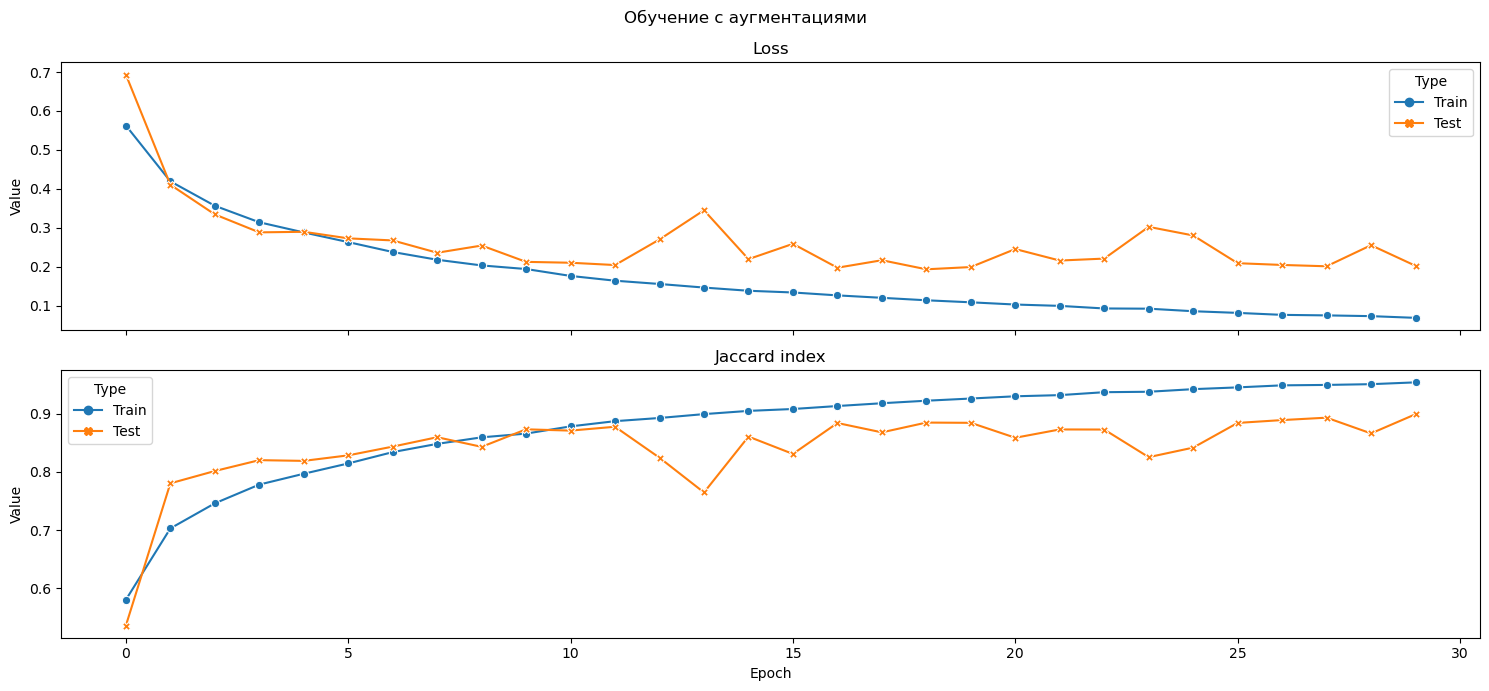

In [149]:
show_stats(train_stats_with_augmentations, test_stats_with_augmentations, "Обучение с аугментациями")

К сожалению, это не дало существенного улучшения.

#### Test-time аугментации

Попробуем сделать test-time аугментации через horizontal flip.

In [150]:
class UNetHFlipWrapper(nn.Module):
    def __init__(self):
        super(UNetHFlipWrapper, self).__init__()
        self.unet = UNET(3, 16, 1)

    def forward(self, x):
        x = torch.cat([x, functional.hflip(x)])
        x = self.unet(x)
        x, x_alt = torch.chunk(x, 2)
        x_alt = functional.hflip(x_alt)
        stacked = torch.stack([x, x_alt])
        means = torch.mean(stacked, dim=0)

        return means

In [151]:
hflip_wrapped_model = UNetHFlipWrapper().cuda()
hflip_wrapped_model.unet.load_state_dict(model.state_dict())

<All keys matched successfully>

In [152]:
print("Flip-wrapped test results (loss, jaccard):", test(hflip_wrapped_model, test_loader))

  0%|          | 0/10 [00:00<?, ?it/s]

Flip-wrapped test results (loss, jaccard): (0.1902061715722084, 0.9017438530921936)


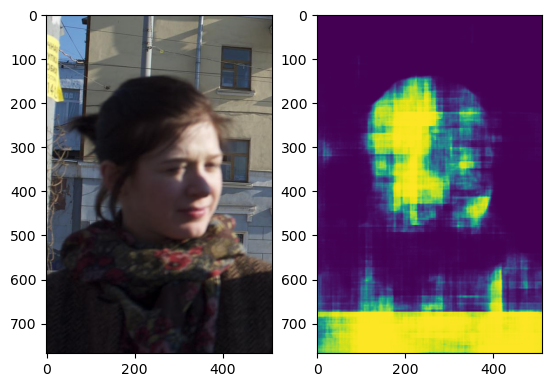

[156]

In [153]:
show_worst_images(hflip_wrapped_model, 1, [])

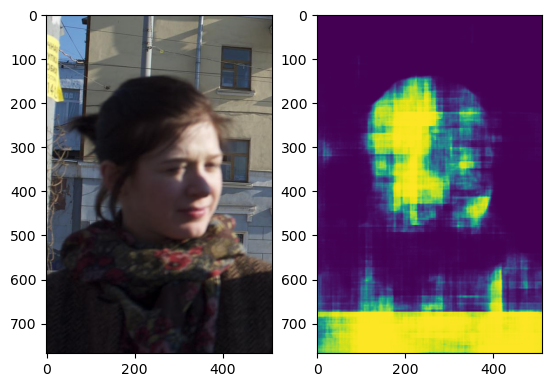

[156]

In [154]:
show_worst_images(hflip_wrapped_model, 1, idx=[worst_idx[0]])

Худшее предсказание с обучения на полном датасете после test-time аугментаций улучшилось: пусть контур выделен не идеально, но лишних выделенных частей стало меньше.

### Улучшение качества, изменяя архитектуру

Добавим в каждый из слоев еще сверток, а именно увеличив их количество до 4.

In [155]:
class EncoderModified(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(EncoderModified, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=4, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class UNETModified(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNETModified, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [156]:
reset_random_seeds()

In [157]:
model = UNETModified(3, 16, 1).cuda()
optimizer = torch.optim.Adam(model.parameters())
train_stats_modified, test_stats_modified = train(
    30, model, train_loader, test_loader, optimizer
)

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1  Train loss:  0.5189583364460203 , train jaccard:  0.6304188327656852 , test loss:  0.46225309669971465 , test jaccard:  0.7003129422664642


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2  Train loss:  0.3834851476881239 , train jaccard:  0.7322524395253923 , test loss:  0.3454864531755447 , test jaccard:  0.7897749483585358


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

3  Train loss:  0.3180127292871475 , train jaccard:  0.7783276710245345 , test loss:  0.41457299888134 , test jaccard:  0.774427056312561


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

4  Train loss:  0.28640016267697016 , train jaccard:  0.8004903184043036 , test loss:  0.2835975229740143 , test jaccard:  0.8348929822444916


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

5  Train loss:  0.25945073796643153 , train jaccard:  0.8189284053113726 , test loss:  0.2715207815170288 , test jaccard:  0.8409141778945923


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

6  Train loss:  0.23373353878657024 , train jaccard:  0.8371328625414106 , test loss:  0.23074835389852524 , test jaccard:  0.8586097657680511


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

7  Train loss:  0.21264371739493476 , train jaccard:  0.8517765455775791 , test loss:  0.2256070375442505 , test jaccard:  0.8618701696395874


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

8  Train loss:  0.19433287729819615 , train jaccard:  0.8651040143436856 , test loss:  0.252508769929409 , test jaccard:  0.8584347605705261


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

9  Train loss:  0.18096859695182907 , train jaccard:  0.8751610649956597 , test loss:  0.225422765314579 , test jaccard:  0.8670324563980103


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

10  Train loss:  0.1672964595258236 , train jaccard:  0.8843034280671014 , test loss:  0.21814594864845277 , test jaccard:  0.8734974265098572


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

11  Train loss:  0.1557556324534946 , train jaccard:  0.8924455218844943 , test loss:  0.22031887620687485 , test jaccard:  0.8754432737827301


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

12  Train loss:  0.14774772044685153 , train jaccard:  0.8975077986717224 , test loss:  0.1894088163971901 , test jaccard:  0.8886287450790405


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

13  Train loss:  0.13768192537956767 , train jaccard:  0.9053449418809679 , test loss:  0.17814599573612214 , test jaccard:  0.8948252439498902


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

14  Train loss:  0.13201425224542618 , train jaccard:  0.9097300847371419 , test loss:  0.16532539278268815 , test jaccard:  0.9017259001731872


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

15  Train loss:  0.12228826143675381 , train jaccard:  0.9160393867227766 , test loss:  0.19427445083856582 , test jaccard:  0.8853359758853913


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

16  Train loss:  0.11762436686290635 , train jaccard:  0.9191840655273862 , test loss:  0.1789466679096222 , test jaccard:  0.8929111361503601


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

17  Train loss:  0.11154296174645424 , train jaccard:  0.923740828037262 , test loss:  0.18188060224056243 , test jaccard:  0.8940183699131012


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

18  Train loss:  0.1077908803605371 , train jaccard:  0.9266785290506151 , test loss:  0.2584004938602448 , test jaccard:  0.8561337113380432


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

19  Train loss:  0.10571562171810203 , train jaccard:  0.9283595078521305 , test loss:  0.22080880850553514 , test jaccard:  0.8745430111885071


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

20  Train loss:  0.10081980447802279 , train jaccard:  0.9315847774346669 , test loss:  0.20381963551044463 , test jaccard:  0.8879028916358948


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

21  Train loss:  0.09272117643720573 , train jaccard:  0.9377256717946795 , test loss:  0.34107729941606524 , test jaccard:  0.8133131742477417


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

22  Train loss:  0.08798108862506018 , train jaccard:  0.9409519612789154 , test loss:  0.23672850877046586 , test jaccard:  0.8696341812610626


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

23  Train loss:  0.08345389866994488 , train jaccard:  0.944174587726593 , test loss:  0.2241112247109413 , test jaccard:  0.8764633119106293


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

24  Train loss:  0.08288513591719998 , train jaccard:  0.9445001277658674 , test loss:  0.21450554132461547 , test jaccard:  0.8850617051124573


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

25  Train loss:  0.07676425108479129 , train jaccard:  0.9490140967898899 , test loss:  0.21058174669742585 , test jaccard:  0.8888300657272339


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

26  Train loss:  0.0711616833590799 , train jaccard:  0.9528514126936595 , test loss:  0.22853714674711229 , test jaccard:  0.8805349409580231


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

27  Train loss:  0.06826253678235743 , train jaccard:  0.9548957182301415 , test loss:  0.21128670051693915 , test jaccard:  0.8963591098785401


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

28  Train loss:  0.06613178269730674 , train jaccard:  0.956459430191252 , test loss:  0.24263381361961364 , test jaccard:  0.8817736864089966


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

29  Train loss:  0.062654675087995 , train jaccard:  0.9590766171614329 , test loss:  0.24546232223510742 , test jaccard:  0.8847664058208465


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

30  Train loss:  0.060008114410771266 , train jaccard:  0.9609206226136949 , test loss:  0.2279874563217163 , test jaccard:  0.8919314980506897


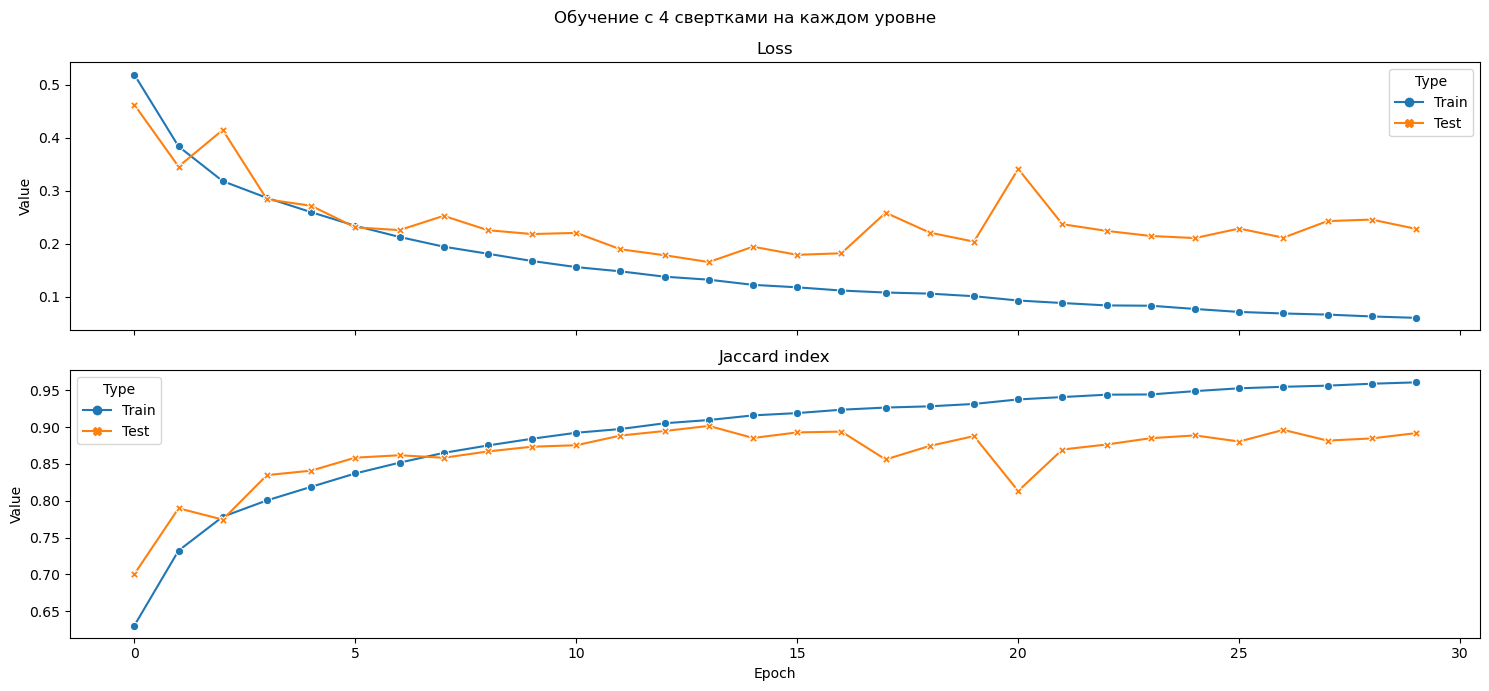

In [158]:
show_stats(train_stats_modified, test_stats_modified, "Обучение с 4 свертками на каждом уровне")

#### Лучшие эпохи
Обучение на полном датасете:

17  Train loss:  0.11320692093835936 , train jaccard:  0.9222997526327769 , test loss:  0.1675563298165798 , test jaccard:  0.9039197087287902

Обучение с аугментациями:

16  Train loss:  0.1339781280193064 , train jaccard:  0.9082457582155864 , test loss:  0.2588660463690758 , test jaccard:  0.8309974789619445

Обучение с изменением архитектуры:

13 Train loss:  0.13768192537956767 , train jaccard:  0.9053449418809679 , test loss:  0.17814599573612214 , test jaccard:  0.8948252439498902




Кажется, что привнесенные изменения только ухудшили результаты по метрикам.

### Выводы

* Изначальная версия U-Net выдает отличные результаты
* Во всех вариантах к 30-ой эпохе можно заметить переобучение
* Визуально добавление test-time аугментаций улучшили результаты
* Улучшения ускоряли время обучения модели, так как номер лучшей эпохи уменьшается